<a href="https://colab.research.google.com/github/gesser000/pacific-anomaly/blob/main/pacific_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr


In [ ]:
agr = pd.read_excel('/content/agr_idx.xlsx')
anomaly = pd.read_excel('/content/anomaly.xlsx')

In [ ]:
anomaly['3m_diff_temp'] = anomaly['Temperature Difference (°C)'].rolling(3).mean()

In [ ]:
anomaly.drop(['Year', 'Month'], axis = 1, inplace = True)
agr.drop(['year', 'month', 'dt_reference'], axis = 1, inplace = True)

In [ ]:
df = pd.merge(agr, anomaly, on = 'data')
df.set_index('data', inplace = True)

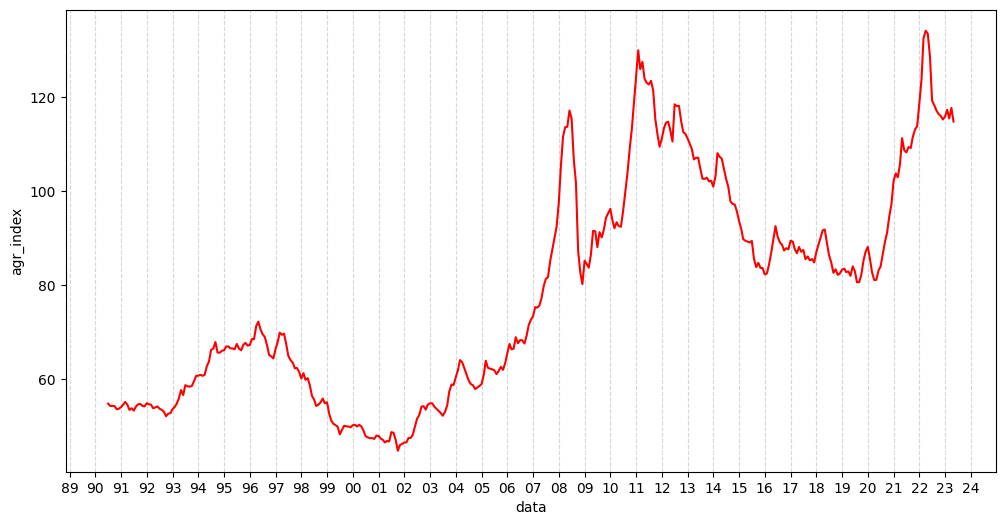

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.lineplot(x = df.index, y = df['agr_index'], color = 'red', ax = ax)

ax.xaxis.set_major_locator(md.MonthLocator(bymonth= 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%y'))
ax.xaxis.grid(alpha = 0.5, linestyle = '--', which = 'major')

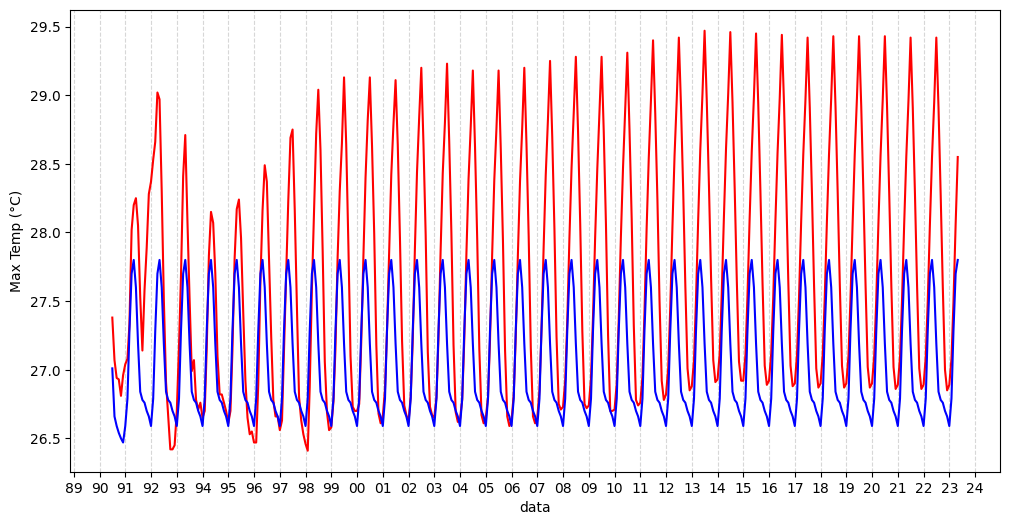

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.lineplot(x = df.index, y = df['Max Temp (°C)'], color = 'red', ax = ax)
sns.lineplot(x = df.index, y = df['Min Temp (°C)'], color = 'blue', ax = ax)

ax.xaxis.set_major_locator(md.MonthLocator(bymonth= 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%y'))
ax.xaxis.grid(alpha = 0.5, linestyle = '--', which = 'major')

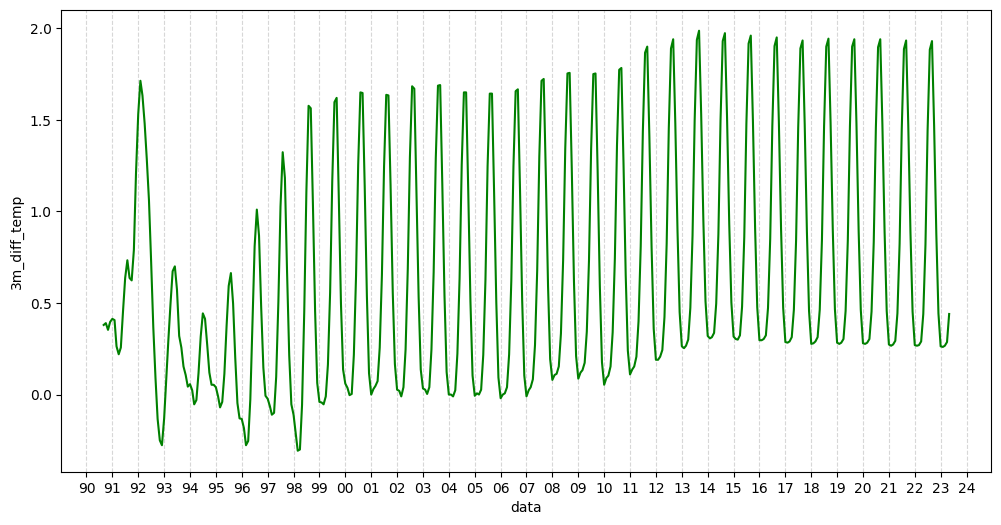

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.lineplot(x = df.index, y = df['3m_diff_temp'], color = 'green', ax = ax)

ax.xaxis.set_major_locator(md.MonthLocator(bymonth= 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%y'))
ax.xaxis.grid(alpha = 0.5, linestyle = '--', which = 'major')

# Normalizar

In [ ]:
def series_normalizer(dado:pd.Series):
  avg = dado.mean()
  sd = dado.std()

  normalized_series = (dado - avg)/sd

  return normalized_series

In [ ]:
agr_idx_normalized = series_normalizer(df['agr_index'])
temp_diff_normalized = series_normalizer(df['Temperature Difference (°C)'])

#Tirando a primeira diferença

In [ ]:
agr_idx_normalized = agr_idx_normalized.diff().dropna()
temp_diff_normalized = temp_diff_normalized.diff().dropna()

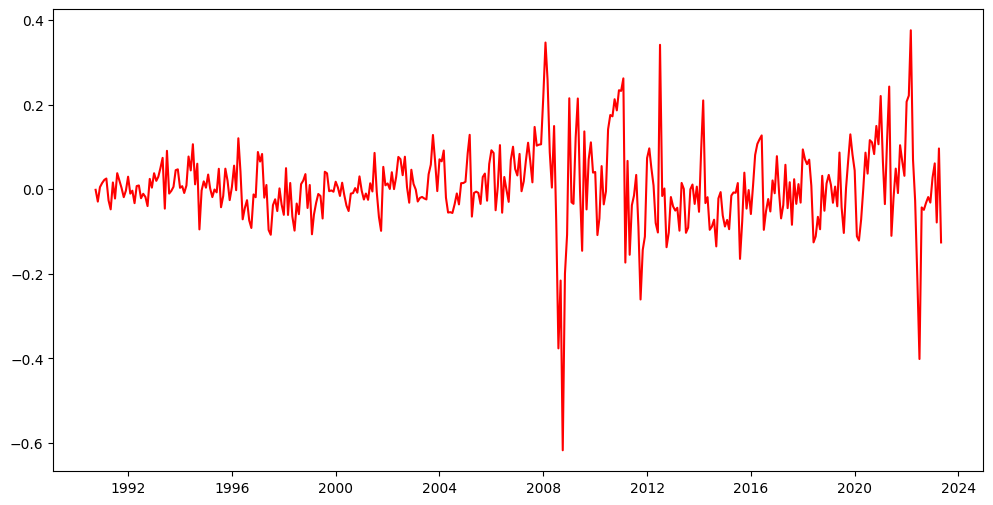

In [ ]:
plt.subplots(figsize = (12, 6))
plt.plot(agr_idx_normalized, color = 'red')

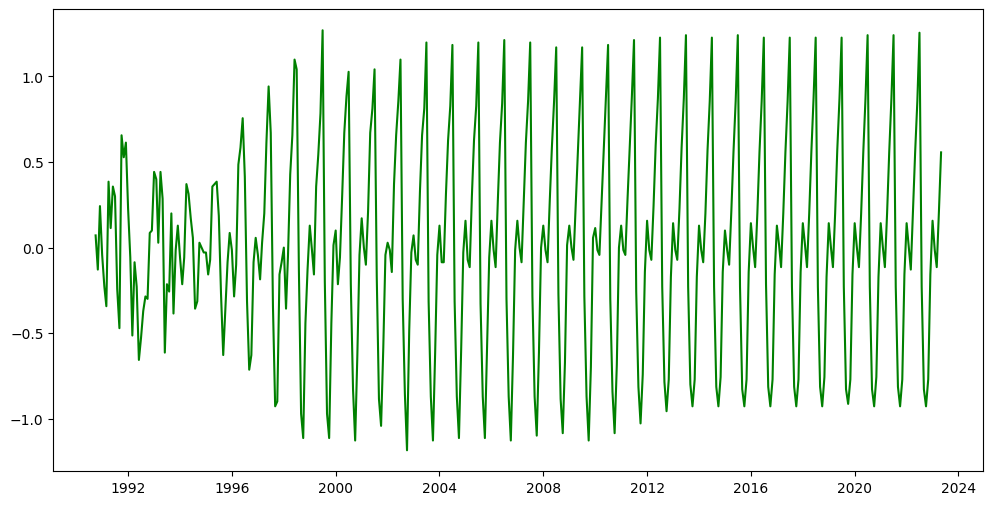

In [ ]:
plt.subplots(figsize = (12, 6))
plt.plot(temp_diff_normalized, color = 'green')

#Remover Aumento de volatilidade

In [ ]:
def anual_std_deviation(dado):
  return dado.groupby(dado.index.year).std()

def apply_std_deviation(dado):
  anual_volatility = anual_std_deviation(dado)
  dado_anual_volatility = dado.index.map(lambda d:  anual_volatility.loc[d.year])

  return dado / dado_anual_volatility

In [ ]:
agr_idx_anual_volatility = apply_std_deviation(agr_idx_normalized)
temp_diff_anual_volatility = apply_std_deviation(temp_diff_normalized)

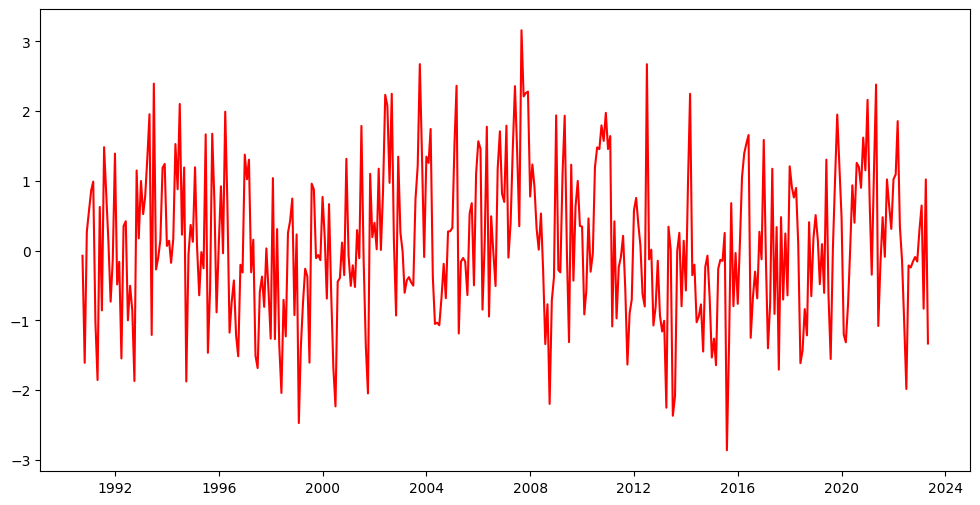

In [ ]:
plt.subplots(figsize = (12, 6))
plt.plot(agr_idx_anual_volatility, color = 'red')

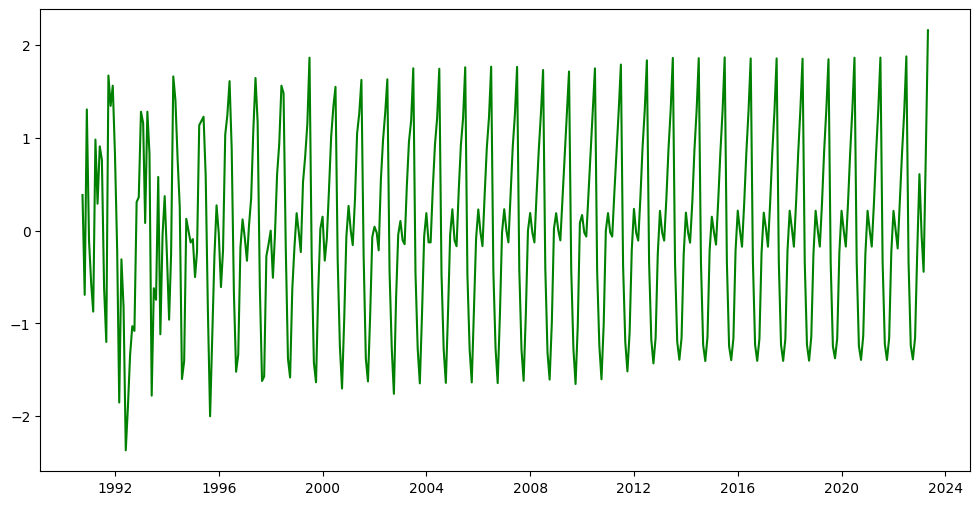

In [ ]:
plt.subplots(figsize = (12, 6))
plt.plot(temp_diff_anual_volatility, color = 'green')

#Removendo Sasionalidade

In [ ]:
def month_avg(dado):
  return dado.groupby(dado.index.month).mean()

def remove_seasonality(dado):
  month_mean = month_avg(dado)
  dado_monthly_mean = dado.index.map(lambda d:  month_mean.loc[d.month])

  return dado - dado_monthly_mean

In [ ]:
agr_idx_no_season = remove_seasonality(agr_idx_anual_volatility)
temp_diff_no_season = remove_seasonality(temp_diff_anual_volatility)

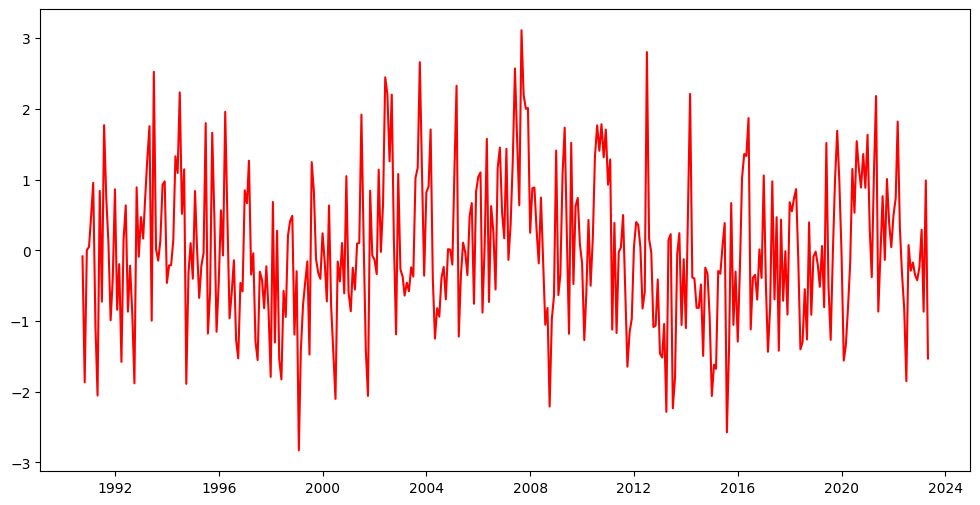

In [ ]:
plt.subplots(figsize = (12, 6))
plt.plot(agr_idx_no_season, color = 'red')

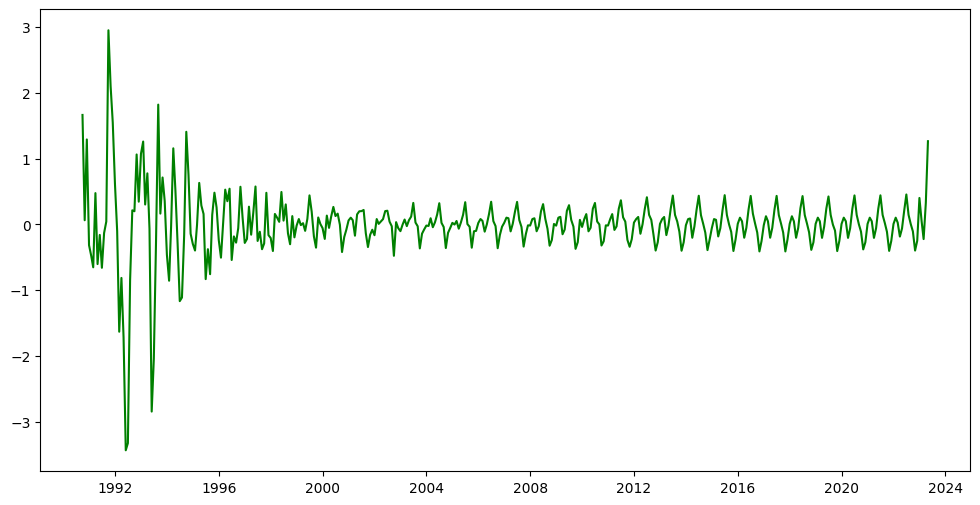

In [ ]:
plt.subplots(figsize = (12, 6))
plt.plot(temp_diff_no_season, color = 'green')

In [ ]:
ad_fuller_result_1 = adfuller(df['agr_index'])

print('Indice Agro')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['Temperature Difference (°C)'])

print('Variação da Temperatura (°C)')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Indice Agro
ADF Statistic: -1.5511668801333218
p-value: 0.5080652722795673

---------------------

Variação da Temperatura (°C)
ADF Statistic: -1.5377318516767553
p-value: 0.5147702717420458


In [ ]:
ad_fuller_result_1 = adfuller(agr_idx_no_season)

print('Indice Agro')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(temp_diff_no_season)

print('Variação da Temperatura (°C)')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Indice Agro
ADF Statistic: -10.287098034475358
p-value: 3.650726855618304e-18

---------------------

Variação da Temperatura (°C)
ADF Statistic: -7.3952555326589575
p-value: 7.808728932845132e-11


#VAR

In [ ]:
df_norm = pd.DataFrame({'agr_idx':agr_idx_no_season, 'temp_diff':temp_diff_no_season})
df_norm.dropna(how = 'any', inplace = True)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


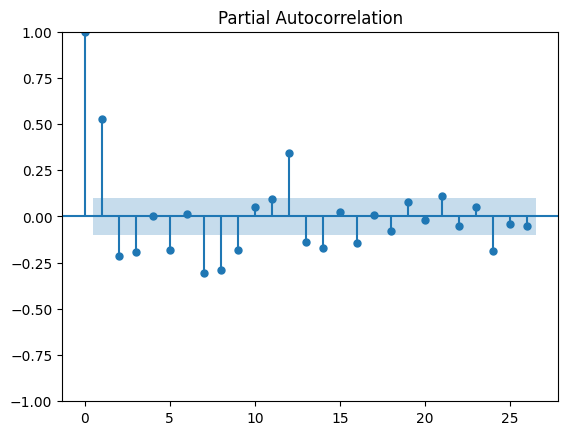

In [ ]:
plot_pacf(df_norm['temp_diff'])
plt.show()

In [ ]:
model = VAR(df_norm)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
sorted_order=model.select_order(maxlags=5)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -1.305      -1.285      0.2711      -1.297
1      -1.773      -1.711      0.1699      -1.748
2      -1.864     -1.762*      0.1551     -1.823*
3      -1.872      -1.729      0.1538      -1.815
4      -1.867      -1.683      0.1545      -1.794
5     -1.900*      -1.675     0.1496*      -1.811
-------------------------------------------------


In [ ]:
model_fit = model.fit(maxlags = 2)

In [ ]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 30, Jun, 2023
Time:                     22:47:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.71051
Nobs:                     390.000    HQIC:                  -1.77190
Log likelihood:          -743.391    FPE:                   0.163293
AIC:                     -1.81221    Det(Omega_mle):        0.159185
--------------------------------------------------------------------
Results for equation agr_idx
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.003247         0.049599            0.065           0.948
L1.agr_idx           0.289595         0.050319            5.755           0.000
L1.temp_diff        -0.206458         0.119219           -1.73

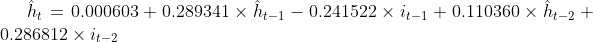